In [3]:
#解压数据集
!unzip data/data70430/signs.zip

Archive:  data/data70430/signs.zip
   creating: signs/
   creating: signs/valid/
   creating: signs/valid/pig/
  inflating: signs/valid/pig/00000563.jpg  
  inflating: signs/valid/pig/00000205.jpg  
  inflating: signs/valid/pig/00000211.jpg  
  inflating: signs/valid/pig/00000577.jpg  
  inflating: signs/valid/pig/00000588.jpg  
  inflating: signs/valid/pig/00000742.jpeg  
  inflating: signs/valid/pig/00000589.jpg  
  inflating: signs/valid/pig/00000210.jpg  
  inflating: signs/valid/pig/00000576.jpg  
  inflating: signs/valid/pig/00000562.jpg  
  inflating: signs/valid/pig/00000238.jpg  
  inflating: signs/valid/pig/00000200.jpeg  
  inflating: signs/valid/pig/00000650.jpeg  
  inflating: signs/valid/pig/00000012.jpg  
  inflating: signs/valid/pig/00000760.jpg  
  inflating: signs/valid/pig/00000199.jpg  
  inflating: signs/valid/pig/00000600.jpg  
  inflating: signs/valid/pig/00000166.jpg  
  inflating: signs/valid/pig/00000172.jpg  
  inflating: signs/valid/pig/00000614.jpg  
  infl

In [1]:
#导入库
import io
import os
import paddle
from PIL import Image
import paddle.io as pio
import paddle.vision.transforms as pt
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


# 导入库后，第一次运行需要标签标注，标注完成后，不再需要运行此代码块

In [4]:
#标签列表
LABEL_MAP=["ratt","ox","tiger","rabbit","dragon","snake","horse","goat","monkey","rooster","dog","pig"]
#根目录
root = 'signs'
#标注生成函数
def Annotation(mode):
    #先创建标注文件
    with open('{}/{}.txt'.format(root,mode),'w') as f:
        #训练，验证，测试三种文件夹路径
        data_dir = '{}/{}'.format(root,mode)
        #遍历文件夹,listdir函数可以返回data_dir下所有文件与文件夹列表
        for path in os.listdir(data_dir):
            #生成标签索引
            label_index = LABEL_MAP.index(path)
            #图像样本路径
            img_path = '{}/{}'.format(data_dir,path)
            #遍历所有图像样本
            for image in os.listdir(img_path):
                #单个图像的样本路径
                image_file = '{}/{}'.format(img_path,image)
                try:
                    with open(image_file,'rb') as f_img:
                        # io.BytesIO将字节对象转为Byte字节流数据,供Image.open使用
                        #f_img.read([size]) 将文件数据作为字符串返回，可选参数size控制读取的字节数
                        image=Image.open(io.BytesIO(f_img.read()))
                        #调用load()方法将强行加载图像数据
                        image.load()
                        if image.mode=='RGB':
                            #写入创建好的text文件
                            f.write('{}\t{}\n'.format(image_file,label_index))
                except:
                    continue
#生成三个数据集标注文件
Annotation(mode = 'train')
Annotation(mode = 'valid')
Annotation(mode = 'test')

# 自定义数据集

In [2]:
#自定义数据集
class MyDataset(pio.Dataset):
    def __init__(self, mode = 'train'):
        super(MyDataset, self).__init__()
        #判断mode参数
        assert mode in ['train', 'test', 'valid'],'mode is one of train, test, valid'
        self.data = []
        #读取对应mode的索引记录
        with open('signs/{}.txt'.format(mode)) as f:
            #按行读取
            for line in f.readlines():
                #去除首尾制表符
                info = line.strip().split('\t')
                if len(info) > 0:
                    #将读取信息添加到data列表中
                    self.data.append([info[0].strip(),info[1].strip()])
        #定义预处理方法，增加样本多样性
        if mode == 'train':
            self.transforms = pt.Compose([
                pt.RandomResizedCrop(size = 224),#随机裁剪大小，从原图裁剪为224*224
                pt.RandomHorizontalFlip(0.5),#以0.5的概率随机水平翻转
                pt.ToTensor(), #转变为张量模式
                pt.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) #归一化
            ])
        else:
            #评估不需要增加样本多样性
            self.transforms=pt.Compose([
                pt.Resize(size=256),#先压缩到256*256
                pt.RandomCrop(size=224),
                pt.ToTensor(),
                pt.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])#归一化
            ])
    def __getitem__(self,index):
        #获取单个样本数据和标签
        image_file,label = self.data[index]
        image = Image.open(image_file)
        #非RGB格式图像转化为RGB格式
        if image.mode != 'RGB':
            image = image.convert('RGB')
        #图像预处理
        image = self.transforms(image)
        #将标签转换为numpy形式
        return image,np.array(label, dtype = 'int64')
    def __len__(self):
        return (len(self.data))

# 创建数据集实例

In [3]:
#创建数据集实例
train_data = MyDataset(mode = 'train')
test_data = MyDataset(mode = 'test')
valid_data = MyDataset(mode = 'valid')
print ('训练集数目: {}, 验证集数目: {}, 测试集数目: {}'.format(len(train_data),len(valid_data),len(test_data)))

训练集数目: 7096, 验证集数目: 639, 测试集数目: 646


# 模型组网
## 构建ConvBN模块

In [4]:
#模型组网RepVGG

#构建ConvBN模块
class ConvBN(nn.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvBN, self).__init__()
        self.conv = nn.Conv2D(in_channels=in_channels, out_channels=out_channels,
                              kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias_attr=False)
        self.bn = nn.BatchNorm2D(num_features=out_channels)

    def forward(self, x):
        # 卷积
        y = self.conv(x)
        
        # 归一化
        y = self.bn(y)
        return y

## 构建RepVGGBlock

In [5]:
#构建RepVGGBlock
class RepVGGBlock(nn.Layer):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros'):
        super(RepVGGBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.padding_mode = padding_mode

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        self.rbr_identity = nn.BatchNorm2D(
            num_features=in_channels) if out_channels == in_channels and stride == 1 else None
        self.rbr_dense = ConvBN(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        self.rbr_1x1 = ConvBN(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=1, stride=stride, padding=padding_11, groups=groups)

    def forward(self, inputs):
        # 判断模型状态，若处于评估预测状态，则启用重排后的模型进行前向计算
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))
        
        # 若处于训练状态下
        if self.rbr_identity is None:
            id_out = 0
        else:
            # 如果 BN 层存在，则计算 BN
            id_out = self.rbr_identity(inputs)
        
        # relu(3X3 ConvBN + 1X1 ConvBN + bn or 0)
        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)
    
    # 重写 eval 函数
    # 在模型评估时对参数进行重新排列
    # 将原来的 3X3 ConvBN、1X1 ConvBN 和 bn 的参数重新排列合并为单个 3X3 的 conv
    def eval(self):
        if not hasattr(self, 'rbr_reparam'):
            self.rbr_reparam = nn.Conv2D(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=self.kernel_size, stride=self.stride,
                                         padding=self.padding, dilation=self.dilation, groups=self.groups, padding_mode=self.padding_mode)
        self.training = False

        # 计算重排后的参数
        # 具体的计算方式请参考上述的图例
        # 或者下方的计算代码
        kernel, bias = self.get_equivalent_kernel_bias()

        # 设置新的参数
        self.rbr_reparam.weight.set_value(kernel)
        self.rbr_reparam.bias.set_value(bias)

        for layer in self.sublayers():
            layer.eval()

    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return nn.functional.pad(kernel1x1, [1, 1, 1, 1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, ConvBN):
            kernel = branch.conv.weight
            running_mean = branch.bn._mean
            running_var = branch.bn._variance
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn._epsilon
        else:
            assert isinstance(branch, nn.BatchNorm2D)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros(
                    (self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = paddle.to_tensor(kernel_value)
            kernel = self.id_tensor
            running_mean = branch._mean
            running_var = branch._variance
            gamma = branch.weight
            beta = branch.bias
            eps = branch._epsilon
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape((-1, 1, 1, 1))
        return kernel * t, beta - running_mean * gamma / std

## 构建RepVGG

In [6]:
#构建RepVGG
class RepVGG(nn.Layer):

    def __init__(self, num_blocks, width_multiplier=None, override_groups_map=None, class_dim=12):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))
        
        # stage0：一个 RepVGGBlock
        self.stage0 = RepVGGBlock(
            in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1)
        self.cur_layer_idx = 1

        # stage1-4：根据配置文件生成对应数量的 RepVGGBlock
        self.stage1 = self._make_stage(
            int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(
            int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(
            int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(
            int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2D(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), class_dim)

    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        # stage0-5
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)

        # 平均池化
        out = self.gap(out)

        # 向量展开
        out = paddle.flatten(out, start_axis=1)

        # 线性变换
        out = self.linear(out)
        return out

# RepVGG模型实例化

In [7]:
model = RepVGG(num_blocks=[2, 4, 14, 1],
    width_multiplier=[0.75, 0.75, 0.75, 2.5], 
    override_groups_map=None)
paddle.summary(model,input_size=(1,3,224,224))

W0611 20:46:50.946663   259 gpu_context.cc:278] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0611 20:46:50.951426   259 gpu_context.cc:306] device: 0, cuDNN Version: 7.6.


-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1        [[1, 3, 224, 224]]   [1, 48, 112, 112]        1,296     
   BatchNorm2D-1    [[1, 48, 112, 112]]   [1, 48, 112, 112]         192      
     ConvBN-1        [[1, 3, 224, 224]]   [1, 48, 112, 112]          0       
     Conv2D-2        [[1, 3, 224, 224]]   [1, 48, 112, 112]         144      
   BatchNorm2D-2    [[1, 48, 112, 112]]   [1, 48, 112, 112]         192      
     ConvBN-2        [[1, 3, 224, 224]]   [1, 48, 112, 112]          0       
      ReLU-1        [[1, 48, 112, 112]]   [1, 48, 112, 112]          0       
   RepVGGBlock-1     [[1, 3, 224, 224]]   [1, 48, 112, 112]          0       
     Conv2D-3       [[1, 48, 112, 112]]    [1, 48, 56, 56]        20,736     
   BatchNorm2D-3     [[1, 48, 56, 56]]     [1, 48, 56, 56]          192      
     ConvBN-3       [[1, 48, 112, 112]]    [1, 48, 56, 56]    

{'total_params': 7866988, 'trainable_params': 7819692}

# 开始训练，首先调整参数

In [8]:
#超参设置
batch_size = 256
epochs = 20
learning_rate = 0.0001
#损失函数:cross_entropy为交叉熵损失，nll为negative log likelihood loss损失
loss_function = 'nll'

#开始训练
train_d = paddle.io.DataLoader(train_data, batch_size=batch_size,shuffle=True,drop_last=True)
valid_d = paddle.io.DataLoader(valid_data, batch_size=batch_size,shuffle=True,drop_last=True)
def train(model,epochs,learning_rate,loss_function,batch_size):
    use_gpu = True
    #资源配置
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

    cross_entropy = paddle.nn.CrossEntropyLoss()
    log_softmax = paddle.nn.LogSoftmax(axis = 1)
    nll = paddle.nn.NLLLoss()

    #用正则化来提升精度
    #opt = paddle.optimizer.Adam(learning_rate=learning_rate,parameters=model.parameters())
    opt = paddle.optimizer.Momentum(learning_rate=learning_rate,parameters=model.parameters(),weight_decay=0.0001)
    iter1 = 0
    iters = []
    losses = []
    acces = []
    model.train()
    #进行数据记录
    for epoch in range(epochs):
        for batch_id,data in enumerate(train_d()):
            image = data[0]
            label = data[1]
            label = paddle.reshape(label,(batch_size,1))
            label_1 = label
            predict = model (image)
            if loss_function == 'cross_entropy':
                loss = cross_entropy(predict,label)
            elif loss_function == 'nll':
                #predict = paddle.reshape(predict,(batch_size,1))
                #predict = paddle.cast(predict,dtype='float32')
                label = paddle.cast(label,dtype='int64')
                predict = log_softmax(predict)
                loss = nll(predict,label)
            else:
                print('wrong loss function')
                exit
            avg_loss=paddle.mean(loss)
            predict_1=nn.functional.softmax(predict)
            acc=paddle.metric.accuracy(predict_1,label_1)
            
            if batch_id % 10 ==0:
                print('epoch_id:{}, batch_id:{}, train_loss:{}, train_acc:{}'.format(epoch,batch_id,avg_loss.numpy(),acc.numpy()))
                iters.append(iter1)
                acces.append(acc.numpy())
                losses.append(avg_loss.numpy())
                iter1 = iter1 + 10
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
        model.eval()
        total_acc = []
        total_loss = []
        #验证数据
        for batch_id,data in enumerate(valid_d()):
            v_image=data[0]
            v_label=data[1]
            v_label=paddle.reshape(v_label,(batch_size,1))
            v_label_1 = v_label
            v_predict=model(v_image)
            if loss_function == 'cross_entropy':
                v_loss = nn.functional.cross_entropy(v_predict,v_label)
            elif loss_function == 'nll':
                #v_predict = paddle.reshape(predict,(batch_size,1))
                #v_predict = paddle.cast(predict,dtype='float32')
                v_label = paddle.cast(v_label,dtype='int64')
                v_predict = log_softmax(v_predict)
                v_loss = nll(v_predict,v_label)
            else:
                print('wrong loss function')
                exit
            v_avg_loss=paddle.mean(v_loss)
            v_predict_1=nn.functional.softmax(v_predict)
            v_acc=paddle.metric.accuracy(v_predict_1,v_label_1)
            v_avg_loss.backward()
            opt.step()
            opt.clear_grad()
            total_loss.append(v_avg_loss.numpy())
            total_acc.append(v_acc.numpy())
        mean_loss=np.mean(total_loss)
        mean_acc=np.mean(total_acc)
        print('epoch_id:{},  valid_loss:{},  valid_acc:{}  '.format(epoch,mean_loss,mean_acc))
        model.train()
    return iters, losses, acces
model = RepVGG(num_blocks=[2, 4, 14, 1],
    width_multiplier=[0.75, 0.75, 0.75, 2.5], 
    override_groups_map=None)
#恢复训练
#params_file_path = './REPVGG_AC.pdparams'
#param_dict = paddle.load(params_file_path)
#model.load_dict(param_dict)
iters,losses,acces=train(model,epochs,learning_rate,loss_function,batch_size)
paddle.save(model.state_dict(),'./REPVGG_MN.pdparams')


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:654: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


epoch_id:0, batch_id:0, train_loss:[2.8865237], train_acc:[0.08203125]
epoch_id:0, batch_id:10, train_loss:[2.8973072], train_acc:[0.05859375]
epoch_id:0, batch_id:20, train_loss:[2.6609454], train_acc:[0.05859375]
epoch_id:0,  valid_loss:2.704288959503174,  valid_acc:0.16015625  
epoch_id:1, batch_id:0, train_loss:[2.6332943], train_acc:[0.0859375]
epoch_id:1, batch_id:10, train_loss:[2.5182889], train_acc:[0.10546875]
epoch_id:1, batch_id:20, train_loss:[2.5119925], train_acc:[0.10546875]
epoch_id:1,  valid_loss:2.4700045585632324,  valid_acc:0.109375  
epoch_id:2, batch_id:0, train_loss:[2.4317565], train_acc:[0.1484375]
epoch_id:2, batch_id:10, train_loss:[2.4807293], train_acc:[0.12109375]
epoch_id:2, batch_id:20, train_loss:[2.414612], train_acc:[0.12109375]
epoch_id:2,  valid_loss:2.43113374710083,  valid_acc:0.125  
epoch_id:3, batch_id:0, train_loss:[2.4635062], train_acc:[0.11328125]
epoch_id:3, batch_id:10, train_loss:[2.4417644], train_acc:[0.11328125]
epoch_id:3, batch_id:

# 测试训练模型

In [4]:
#模型评估测试
test_d=paddle.io.DataLoader(test_data,batch_size=32,shuffle=True,drop_last=True)
def evalution(model):
    print("evalution start......")
    #读取模型文件
    params_file_path = './0608_1.pdparams'
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)
    model.eval()
    e_total_acc=[]
    e_total_loss=[]
    tp=0
    fn=0
    fp=0
    tn=0
    for batch_id,data in enumerate(test_d()):
        img = data[0]
        label=data[1]
        label=paddle.reshape(label,(32,1))
        predict=model(img)
        #loss值获取
        loss=nn.functional.cross_entropy(predict,label)
        avg_loss=paddle.mean(loss)

        #accuracy获取
        predict_1=nn.functional.softmax(predict)
        predict_2=nn.functional.sigmoid(predict)
        acc=paddle.metric.accuracy(predict_1,label)
        e_total_acc.append(acc.numpy())
        e_total_loss.append(avg_loss.numpy())
        print(predict)
        print(predict_1)
        print(label)
        return

        print(type(predict))
        print(type(predict_1))

        #precision获取
        #recall获取
    acc=np.mean(e_total_acc)
    loss=np.mean(e_total_loss)
    prec=
    recall=
    print('test_loss:{}, test_acc:{}, test_error:{}, test_precision:{}, test_recall:{}'.format(loss,acc,1-acc,prec,recall))
model=VGG()
evalution(model)


evalution start......
Tensor(shape=[32, 12], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[-2.40907645 ,  3.37380648 , -3.26359630 , -2.95006013 ,  1.91786134 ,
         -2.50426245 ,  4.82265139 ,  2.00100946 , -3.06227899 ,  3.32317710 ,
          1.00109458 , -3.48613787 ],
        [-4.80072594 ,  9.01554298 , -2.19774079 , -2.40995812 , -5.47204971 ,
         -6.41425610 ,  2.54445291 ,  10.19836330, -0.12604778 , -2.48529100 ,
          2.26609850 ,  0.18553492 ],
        [ 23.11033249, -3.41590786 , -9.60511684 ,  5.23354673 , -0.56093168 ,
         -4.42958450 , -4.48463917 , -3.86223602 , -2.56281590 , -4.61674356 ,
         -2.47049546 ,  5.85145760 ],
        [-1.77635396 ,  0.32984596 ,  1.05050313 ,  0.49846110 , -1.35029137 ,
          0.82978499 ,  0.22365177 ,  0.47979578 , -0.43571502 , -0.01840392 ,
         -0.32702869 ,  0.17696646 ],
        [ 0.90796494 ,  1.19482374 , -1.82967329 , -0.62090015 ,  0.98908603 ,
         -3.27333355 ,  0.74510103 ,

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:654: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


f1_score: 0.13239455349554455
accuracy: 0.1484375
error rate: 0.8515625
precision: 0.15577746392424874
recall: 0.14953867818647693


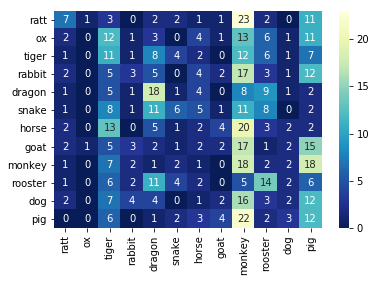

In [11]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,classification_report
import pandas as pd
import seaborn as sns

params_file_path = './REPVGG_MN.pdparams'
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
test_d=paddle.io.DataLoader(test_data,batch_size=32,shuffle=True,drop_last=True)
y_p = []
y_t = []
for batch, (test_X,test_y) in enumerate(test_d):
    y_pred = model(test_X)
    for i in y_pred:
        y_p.append(np.argmax(i))
    #y_p.append(y_pred)
    for i in test_y:
        y_t.append(int(i))

cm = confusion_matrix(y_t,y_p)
cm = pd.DataFrame(cm,columns=["ratt","ox","tiger","rabbit","dragon","snake","horse","goat","monkey","rooster","dog","pig"],index=["ratt","ox","tiger","rabbit","dragon","snake","horse","goat","monkey","rooster","dog","pig"])
sns.heatmap(cm,cmap="YlGnBu_r",fmt="d",annot=True)

print('f1_score:',f1_score(y_t,y_p,average='macro'))
print('accuracy:',accuracy_score(y_t,y_p))
print('error rate:',1-accuracy_score(y_t,y_p))
print('precision:',precision_score(y_t,y_p,average='macro'))
print('recall:',recall_score(y_t,y_p,average='macro'))